# Food Manufacture I

## Objective and Prerequisites 

If you’re hungry for a mathematical optimization challenge, then try this food manufacturing problem. You’ll learn how to create an optimal multi-period production plan for a product that requires a number of ingredients – each of which has different costs, restrictions, and features.

More information on this type of model can be found in example #1 of the fifth edition of Modeling Building in Mathematical Programming by H. P. Williams on pages 253 – 254 and 296 – 298.

This modeling example is at the intermediate level, where we assume that you know Python and are familiar with the Gurobi Python API. In addition, you should have some knowledge about building mathematical optimization models.

**Download the Repository** <br />
You can download the repository containing this and other examples by clicking [here](https://github.com/Gurobi/modeling-examples/archive/master.zip). 

---
## Problem Description

A manufacturer needs to refine several raw oils and blend them together to produce a given food product that can be sold. The raw oils required can be divided into two categories:


| Category        | Oil         |
| ------------- |-------------| 
| Vegetable oils:|  VEG 1<br>VEG 2 | 
| Non-vegetable oils:     | OIL 1<br>OIL 2<br>OIL 3      |

The manufacturer can choose to buy raw oils for the current month and/or buy them on the futures market for delivery in a subsequent month. Prices for immediate delivery and in the futures market are given below in USD/ton:

| Month |	VEG 1 |	VEG 2 |	OIL 1 |	OIL 2 |	OIL 3|
| ------------- |-------------| -------------| -------------| -------------| -------------| 
| January| 110 |	120 |	130 |	110 |	115|
| February |130 |	130 |	110 |	90|	115|
| March |110 |	140 |	130 |	100 |	95|
| April |120 |	110 |	120 |	120 |	125|
| May | 100 |	120 |	150 |	110 |	105|
| June |  	90 |	100 |	140 |	80| 	135 |

There are a number of additional factors that must be taken into account. These include:

1. The final food product sells for $\$150$ per ton.
2. Each category of oil (vegetable and non-vegetable) needs to be refined on a different production line.
3. There is limited refinement capacity such that in any given month a maximum of 200 tons of vegetable oils and 250 tons of non-vegetable oils can be refined.
4. Also, there is no waste in the refinement process, so the sum of the raw oils refined will equal the amount of refined oils available.
5. The cost of refining the oils may be ignored.

In addition to the refining limits above, there are limits to the amount of raw oils that can be stored for future use, and there is a cost associated with each ton of oil stored. The limit is 1,000 tons of each raw oil and the storage cost is $\$5$ per ton per month. The manufacturer cannot store the produced food product or the refined oils.

The final food product must have a hardness between three and six on a given hardness scale. For the purposes of the model, hardness blends linearly and the hardness of each raw oil is:

|Oils |	Hardness|
| ------------- |-------------| 
|VEG 1 |	8.8|
|VEG 2 |	6.1|
|OIL 1 |	2.0|
|OIL2 |	4.2|
|OIL 3| 	5.0|

At the start of January, there are 500 tons of each type of raw oil in storage. For the purpose of the model, this should also be the level of raw oils in storage at the end of June.

Given the above information, what monthly buying and manufacturing decisions should be made in order to maximize profit?

---
## Model Formulation

### Sets and Indices

$t \in \text{Months}=\{\text{Jan},\text{Feb},\text{Mar},\text{Apr},\text{May},\text{Jun}\}$: Set of months.

$V=\{\text{VEG1},\text{VEG2}\}$: Set of vegetable oils.

$N=\{\text{OIL1},\text{OIL2},\text{OIL3}\}$: Set of non-vegetable oils.

$o \in \text{Oils} = V \cup N$: Set of oils.

### Parameters

$\text{price} \in \mathbb{R}^+$: Sale price of the final product.

$\text{init_store} \in \mathbb{R}^+$: Initial storage amount in tons.

$\text{target_store} \in \mathbb{R}^+$: Target storage amount in tons.

$\text{holding_cost} \in \mathbb{R}^+$: Monthly cost (in USD/ton/month) of keeping in inventory a ton of oil.

$\text{veg_cap} \in \mathbb{R}^+$: Installed capacity (in tons) to refine vegetable oils.

$\text{oil_cap} \in \mathbb{R}^+$: Installed capacity (in tons) to refine non-vegetable oils.

$\text{min_hardness} \in \mathbb{R}^+$: lowest hardness allowed for the final product.

$\text{max_hardness} \in \mathbb{R}^+$: highest hardness allowed for the final product.

$\text{hardness}_o \in \mathbb{R}^+$: Hardness of oil $o$.

$\text{cost}_{t,o} \in \mathbb{R}^+$: Estimated purchase price for oil $o$ at month $t$.


### Decision Variables

$\text{produce}_t \in \mathbb{R}^+$: Tons of food to produce at month $t$.

$\text{buy}_{t,o} \in \mathbb{R}^+$: Tons of oil $o$ to buy at month $t$.

$\text{consume}_{t,o} \in \mathbb{R}^+$: Tons of oil $o$ to use at month $t$.

$\text{store}_{t,o} \in \mathbb{R}^+$: Tons of oil $o$ to store at month $t$.


### Objective Function

- **Profit**: Maximize the total profit (in USD) of the planning horizon.

\begin{equation}
\text{Maximize} \quad Z = \sum_{t \in \text{Months}}\text{price}*\text{produce}_t - \sum_{t \in \text{Months}}\sum_{o \in \text{Oils}}(\text{cost}_{t,o}*\text{consume}_{t,o} + \text{holding_cost}*\text{store}_{t,o})
\tag{0}
\end{equation}

### Constraints

- **Initial Balance:** The Tons of oil $o$ purchased in January and the ones previously stored should be equal to the Tons of said oil consumed and stored in that month.

\begin{equation}
\text{init_store} + \text{buy}_{Jan,o} = \text{consume}_{Jan,o} + \text{store}_{Jan,o} \quad \forall o \in \text{Oils}
\tag{1}
\end{equation}

- **Balance:** The Tons of oil $o$ purchased in month $t$ and the ones previously stored should be equal to the Tons of said oil consumed and stored in that month.

\begin{equation}
\text{store}_{t-1,o} + \text{buy}_{t,o} = \text{consume}_{t,o} + \text{store}_{t,o} \quad \forall (t,o) \in \text{Months} \setminus \{\text{Jan}\} \times \text{Oils}
\tag{2}
\end{equation}

- **Inventory Target**: The Tons of oil $o$ kept in inventory at the end of the planning horizon should hit the target.

\begin{equation}
\text{store}_{Jun,o} = \text{target_store} \quad \forall o \in \text{Oils}
\tag{3}
\end{equation}

- **Refinement Capacity**: Total Tons of oil $o$ consumed in month $t$ cannot exceed the refinement capacity.

\begin{equation}
\sum_{o \in V}\text{consume}_{t,o} \leq \text{veg_cap} \quad \forall t \in \text{Months}
\tag{4.1}
\end{equation}

\begin{equation}
\sum_{o \in N}\text{consume}_{t,o} \leq \text{oil_cap} \quad \forall t \in \text{Months}
\tag{4.2}
\end{equation}

- **Hardness**: The hardness value of the food produced in month $t$ should be within tolerances.

\begin{equation}
\text{min_hardness}*\text{produce}_t \leq \sum_{o \in \text{Oils}} \text{hardness}_o*\text{consume}_{t,o} \leq \text{max_hardness}*\text{produce}_t \quad \forall t \in \text{Months}
\tag{5}
\end{equation}

- **Mass Conservation**: Total Tons of oil consumed in month $t$ should be equal to the Tons of the food produced in that month.

\begin{equation}
\sum_{o \in \text{Oils}}\text{consume}_{t,o} = \text{produce}_t \quad \forall t \in \text{Months}
\tag{6}
\end{equation}

---
## Python Implementation

We import the Gurobi Python Module and other Python libraries.

In [3]:
import numpy as np
import pandas as pd

import gurobipy as gp
from gurobipy import GRB
from IPython.display import Image 
# tested with Python 3.7 & Gurobi 9

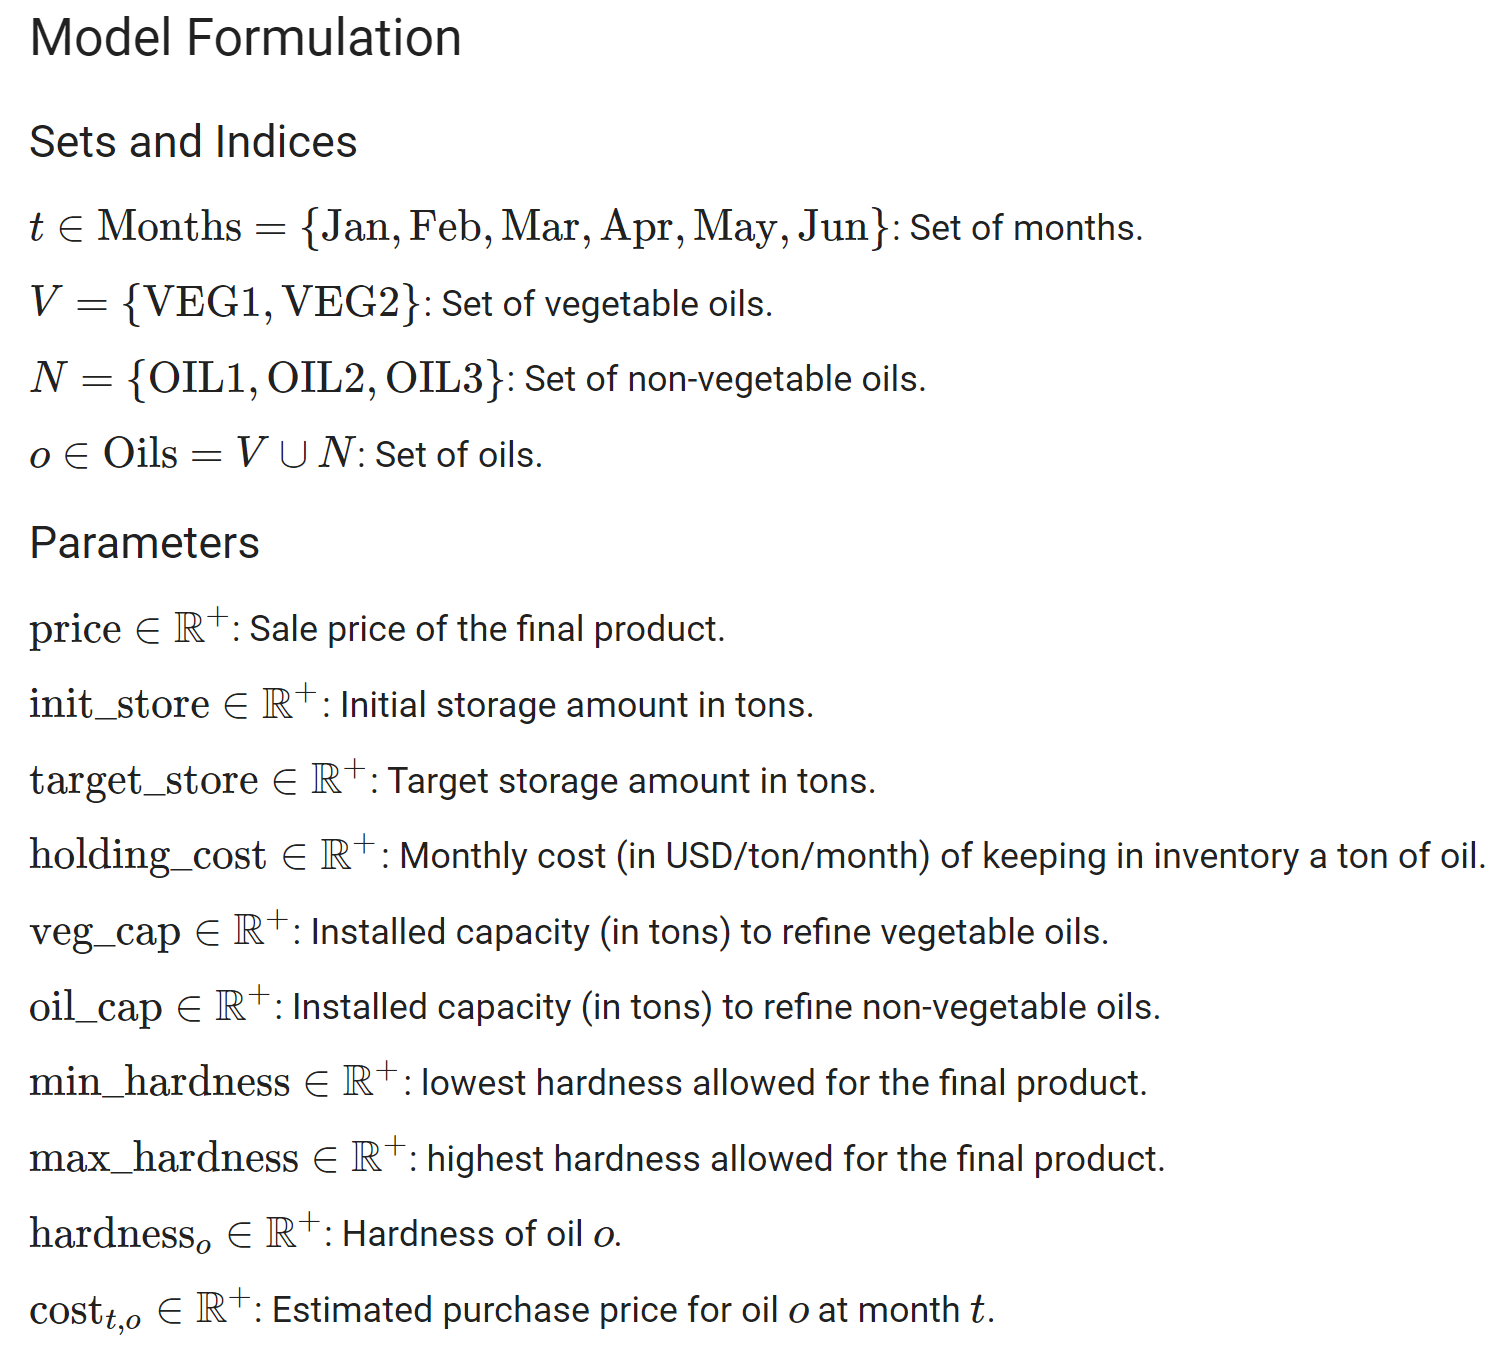

In [9]:
# Math Model: 
Image("food-1-model1.png", width=600, height=350) 

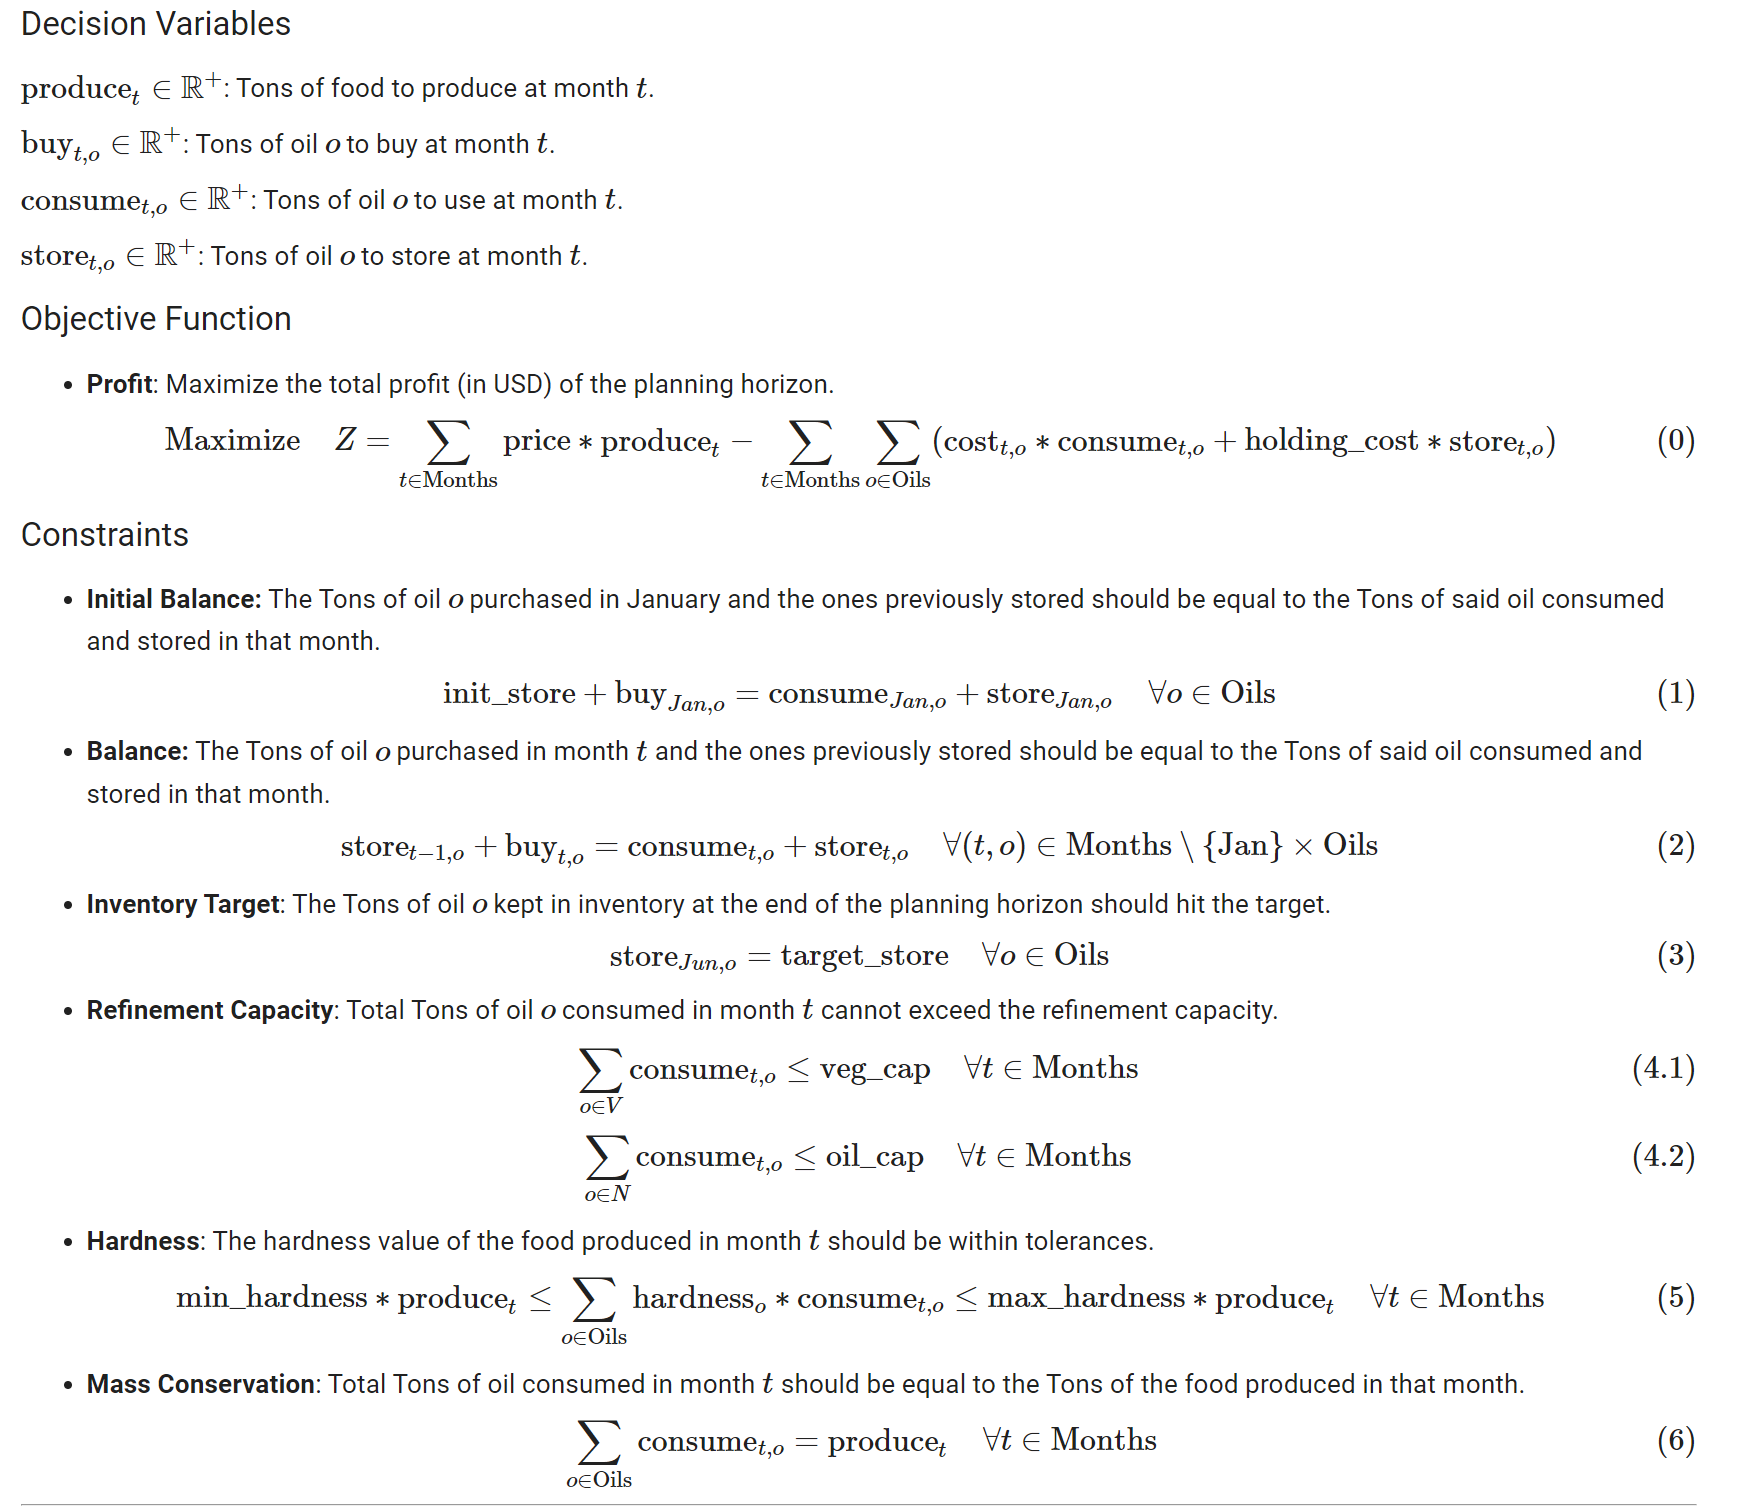

In [12]:
Image("food-1-model2.png", width=900, height=550) 

## Input Data
We define all the input data of the model.

In [7]:
# Parameters

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun"]

oils = ["VEG1", "VEG2", "OIL1", "OIL2", "OIL3"]

cost = {
    ('Jan', 'VEG1'): 110,
    ('Jan', 'VEG2'): 120,
    ('Jan', 'OIL1'): 130,
    ('Jan', 'OIL2'): 110,
    ('Jan', 'OIL3'): 115,
    ('Feb', 'VEG1'): 130,
    ('Feb', 'VEG2'): 130,
    ('Feb', 'OIL1'): 110,
    ('Feb', 'OIL2'): 90,
    ('Feb', 'OIL3'): 115,
    ('Mar', 'VEG1'): 110,
    ('Mar', 'VEG2'): 140,
    ('Mar', 'OIL1'): 130,
    ('Mar', 'OIL2'): 100,
    ('Mar', 'OIL3'): 95,
    ('Apr', 'VEG1'): 120,
    ('Apr', 'VEG2'): 110,
    ('Apr', 'OIL1'): 120,
    ('Apr', 'OIL2'): 120,
    ('Apr', 'OIL3'): 125,
    ('May', 'VEG1'): 100,
    ('May', 'VEG2'): 120,
    ('May', 'OIL1'): 150,
    ('May', 'OIL2'): 110,
    ('May', 'OIL3'): 105,
    ('Jun', 'VEG1'): 90,
    ('Jun', 'VEG2'): 100,
    ('Jun', 'OIL1'): 140,
    ('Jun', 'OIL2'): 80,
    ('Jun', 'OIL3'): 135
}


hardness = {"VEG1": 8.8, "VEG2": 6.1, "OIL1": 2.0, "OIL2": 4.2, "OIL3": 5.0}

price = 150
init_store = 500
target_store = 500
veg_cap = 200
oil_cap = 250

min_hardness = 3
max_hardness = 6
holding_cost = 5

## Model Deployment
We create a model and the variables. For each period, we create a variable which will take into account the value of the food produced. For each product (5 kinds of oils) and each period, we will create variables for the amount that gets bought, used and, stored.

In [8]:
food = gp.Model('Food Manufacture I')
# Quantity of food produced in each period
produce = food.addVars(months, name="Produce")
# Quantity bought of each product in each period
buy = food.addVars(months, oils, name = "Buy")
# Quantity used of each product  in each period
consume = food.addVars(months, oils, name = "Use")
# Quantity stored of each product  in each period
store = food.addVars(months, oils, name = "Store")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-29


Next, we insert the constraints. The balance constraints ensure that the amount of oil that is in the storage in the previous period plus the amount that gets purchased equals the amount that is used plus the amount that is stored in the current period (for each oil). 

In [9]:
#1. Initial Balance
Balance0 = food.addConstrs((init_store + buy[months[0], oil]
                 == consume[months[0], oil] + store[months[0], oil]
                 for oil in oils), "Initial_Balance")

#2. Balance
Balance = food.addConstrs((store[months[months.index(month)-1], oil] + buy[month, oil]
                 == consume[month, oil] + store[month, oil]
                 for oil in oils for month in months if month != month[0]), "Balance")

The Inventory Target constraints force that at the end of the last period the storage contains the initial amount of each product.

In [10]:
#3. Inventory Target
TargetInv = food.addConstrs((store[months[-1], oil] == target_store for oil in oils),"End_Balance")

The capacity constraints restrict the amount of veg and non-veg oils that can be processed per period.

In [11]:
#4.1 Vegetable Oil Capacity
VegCapacity = food.addConstrs((gp.quicksum(consume[month, oil] for oil in oils if "VEG" in oil)
                 <= veg_cap for month in months), "Capacity_Veg")

#4.2 Non-vegetable Oil Capacity
NonVegCapacity = food.addConstrs((gp.quicksum(consume[month, oil] for oil in oils if "OIL" in oil)
                 <= oil_cap for month in months), "Capacity_Oil")

The hardness constraints limit the hardness of the final product, which needs to remain between 3 and 6.

In [12]:
#5. Hardness
HardnessMin = food.addConstrs((gp.quicksum(hardness[oil]*consume[month, oil] for oil in oils)
                 >= min_hardness*produce[month] for month in months), "Hardness_lower")
HardnessMax = food.addConstrs((gp.quicksum(hardness[oil]*consume[month, oil] for oil in oils)
                 <= max_hardness*produce[month] for month in months), "Hardness_upper")

The Mass Conservation constraints ensure that the amount of oil used in each period equals the food produced in this period.

In [13]:
#6. Mass Conservation
MassConservation = food.addConstrs((consume.sum(month) == produce[month] for month in months), "Mass_conservation")

The objective is to maximize the profit of the company, which includes the revenue as well as the costs for buying and storing the used products.

In [14]:
#0. Objective Function
obj = price*produce.sum() - buy.prod(cost) - holding_cost*store.sum()
food.setObjective(obj, GRB.MAXIMIZE) # maximize profit

Next, we start the optimization and Gurobi finds the optimal solution.

In [15]:
food.optimize()

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 5 5600G with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 70 rows, 96 columns and 278 nonzeros
Model fingerprint: 0x7d311b4b
Coefficient statistics:
  Matrix range     [1e+00, 9e+00]
  Objective range  [5e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 5e+02]
Presolve removed 33 rows and 45 columns
Presolve time: 0.01s
Presolved: 37 rows, 51 columns, 149 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.7375000e+05   1.703125e+03   0.000000e+00      0s
      29    1.0784259e+05   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.078425926e+05


---
## Analysis

The highest profit we can hope for is $\$107,842.6$. Let's see an optimal solution needed to achieve that figure (there are alternative optimal solutions):

### Purchase Plan

This plan defines the amount of vegetable oil (VEG) and non-vegetable oil (OIL) that we need to purchase during the planning horizon. For example, 659.3 tons of vegetable oil of type VEG1 needs to be bought in June.

In [11]:
rows = months.copy()
columns = oils.copy()
purchase_plan = pd.DataFrame(columns=columns, index=rows, data=0.0)

for month, oil in buy.keys():
    if (abs(buy[month, oil].x) > 1e-6):
        purchase_plan.loc[month, oil] = np.round(buy[month, oil].x, 1)
purchase_plan

,VEG1,VEG2,OIL1,OIL2,OIL3
Jan,0.0,0.0,0.0,0.0,0.0
Feb,0.0,0.0,0.0,250.0,0.0
Mar,0.0,0.0,0.0,0.0,0.0
Apr,0.0,0.0,0.0,0.0,0.0
May,0.0,0.0,0.0,0.0,500.0
Jun,659.3,540.7,0.0,750.0,0.0


### Monthly Consumption

This plan determines the amount of vegetable oil (VEG) and non-vegetable oil (OIL) consumed during the planning horizon. For example, 200 tons of vegetable oil of type VEG2 is consumed in January.

In [12]:
rows = months.copy()
columns = oils.copy()
reqs = pd.DataFrame(columns=columns, index=rows, data=0.0)

for month, oil in consume.keys():
    if (abs(consume[month, oil].x) > 1e-6):
        reqs.loc[month, oil] = np.round(consume[month, oil].x, 1)
reqs

,VEG1,VEG2,OIL1,OIL2,OIL3
Jan,0.0,200.0,0.0,0.0,250.0
Feb,85.2,114.8,0.0,0.0,250.0
Mar,96.3,103.7,0.0,250.0,0.0
Apr,159.3,40.7,0.0,250.0,0.0
May,159.3,40.7,0.0,250.0,0.0
Jun,159.3,40.7,0.0,250.0,0.0


### Inventory Plan

This plan reflects the amount of vegetable oil (VEG) and non-vegetable oil (OIL) in inventory at the end of each period of  the planning horizon. For example, at the end of February we have 500 tons of Non-vegetable oil of type OIL1.

In [13]:
rows = months.copy()
columns = oils.copy()
store_plan = pd.DataFrame(columns=columns, index=rows, data=0.0)

for month, oil in store.keys():
    if (abs(store[month, oil].x) > 1e-6):
        store_plan.loc[month, oil] = np.round(store[month, oil].x, 1)
store_plan

,VEG1,VEG2,OIL1,OIL2,OIL3
Jan,500.0,300.0,500.0,500.0,250.0
Feb,414.8,185.2,500.0,750.0,0.0
Mar,318.5,81.5,500.0,500.0,0.0
Apr,159.3,40.7,500.0,250.0,0.0
May,0.0,0.0,500.0,0.0,500.0
Jun,500.0,500.0,500.0,500.0,500.0


**Note:** If you want to write your solution to a file, rather than print it to the terminal, you can use the model.write() command. An example implementation is:

`food.write("food-manufacture-1-output.sol")`

---
## References

H. Paul Williams, Model Building in Mathematical Programming, fifth edition.

Copyright © 2020 Gurobi Optimization, LLC